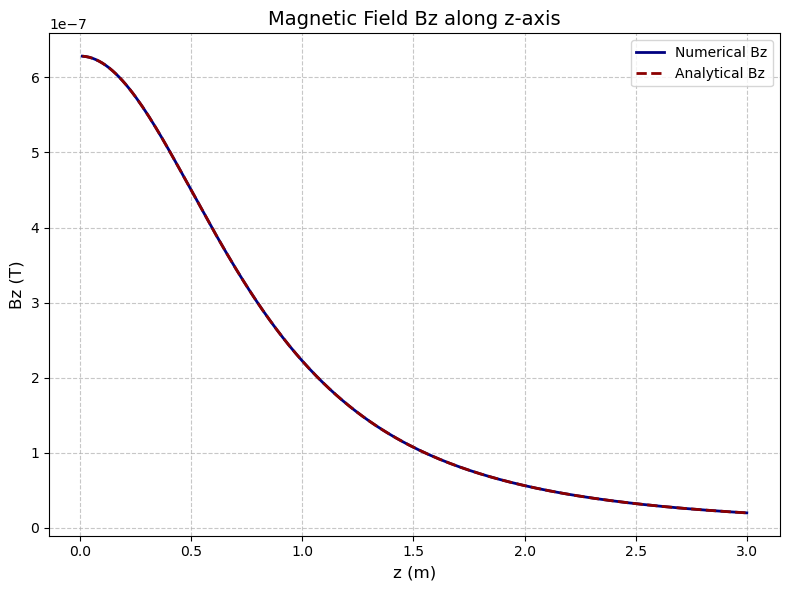

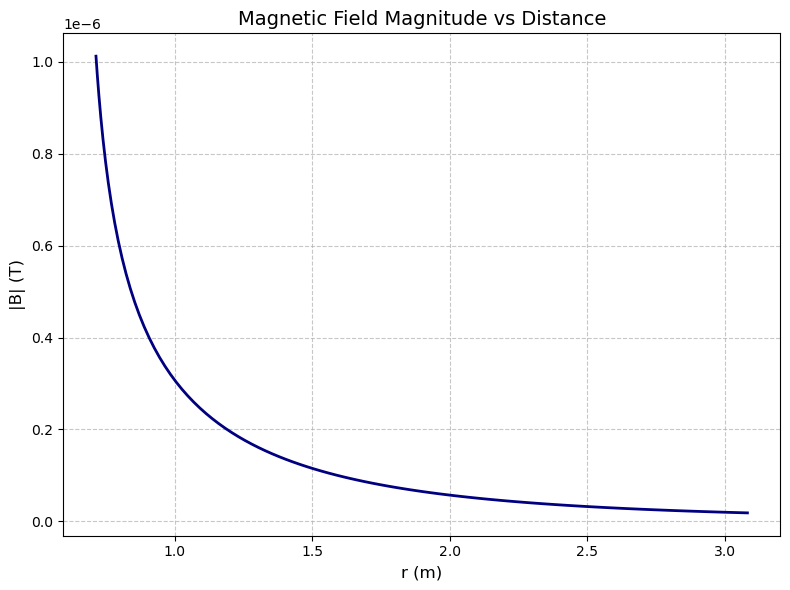

/var/folders/jz/1ytqmx1s719c9p1xkxg8bhk80000gn/T/ipykernel_2417/4076948512.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('field_map_xz_plot.png', dpi=dpi, bbox_inches='tight')
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


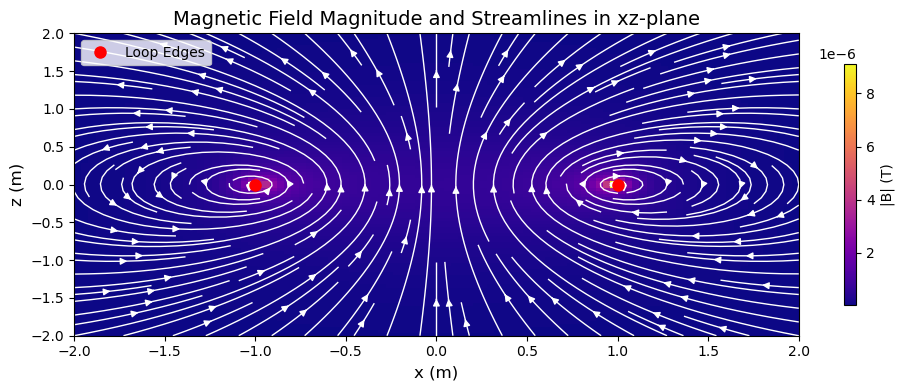

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss
from matplotlib.collections import LineCollection

# Constants
MU0 = 4 * np.pi * 1e-7  # Permeability of free space (T·m/A)

def biot_savart_integrand(theta, R, I, obs_point):
    """
    Compute the Biot-Savart integrand for a circular loop in the xy-plane.

    Parameters:
        theta (float): Angular position along the loop (radians).
        R (float): Radius of the loop (m).
        I (float): Current in the loop (A).
        obs_point (tuple): Observation point coordinates (x, y, z).

    Returns:
        np.ndarray: Contribution to the magnetic field at the observation point.
    """
    x, y, z = obs_point
    r_prime = np.array([R * np.cos(theta), R * np.sin(theta), 0])
    dl = R * np.array([-np.sin(theta), np.cos(theta), 0])
    r = np.array([x, y, z]) - r_prime
    norm_r = np.linalg.norm(r)
    if norm_r < 1e-10:  # Avoid division by zero
        return np.zeros(3)
    cross = np.cross(dl, r)
    return MU0 * I / (4 * np.pi) * cross / norm_r**3

def compute_magnetic_field(R, I, obs_point, N=100):
    """
    Compute the magnetic field at an observation point using Gauss-Legendre quadrature.

    Parameters:
        R (float): Radius of the loop (m).
        I (float): Current in the loop (A).
        obs_point (tuple): Observation point coordinates (x, y, z).
        N (int): Number of quadrature points.

    Returns:
        np.ndarray: Magnetic field vector [Bx, By, Bz] at the observation point.
    """
    if R <= 0:
        raise ValueError("Loop radius (R) must be positive.")
    if N < 1:
        raise ValueError("Number of quadrature points (N) must be positive.")

    xi, wi = leggauss(N)
    theta_i = 0.5 * (xi + 1) * 2 * np.pi  # Map [-1, 1] to [0, 2π]
    weights = 0.5 * 2 * np.pi * wi

    B = np.zeros(3)
    for theta, w in zip(theta_i, weights):
        B += biot_savart_integrand(theta, R, I, obs_point) * w
    return B

def plot_bz_vs_z(R, I, z_range, figsize=(8, 6), dpi=300):
    """
    Plot Bz component along the z-axis and compare with the analytical solution.

    Parameters:
        R (float): Radius of the loop (m).
        I (float): Current in the loop (A).
        z_range (tuple): Range of z values (z_min, z_max).
        figsize (tuple): Figure size for the plot.
        dpi (int): Resolution for the saved plot.

    Returns:
        None: Generates and saves the plot.
    """
    z_vals = np.linspace(z_range[0], z_range[1], 200)
    Bz_numeric = [compute_magnetic_field(R, I, (0, 0, z))[2] for z in z_vals]
    Bz_exact = [MU0 * I * R**2 / (2 * (R**2 + z**2)**(3/2)) for z in z_vals]

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(z_vals, Bz_numeric, label='Numerical Bz', lw=2, color='navy')
    ax.plot(z_vals, Bz_exact, '--', label='Analytical Bz', lw=2, color='darkred')
    ax.set_xlabel('z (m)', fontsize=12)
    ax.set_ylabel('Bz (T)', fontsize=12)
    ax.set_title('Magnetic Field Bz along z-axis', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('bz_vs_z_plot.png', dpi=dpi, bbox_inches='tight')
    plt.show()

def plot_b_magnitude_vs_r(R, I, trajectory, figsize=(8, 6), dpi=300):
    """
    Plot the magnitude of the magnetic field along a given trajectory.

    Parameters:
        R (float): Radius of the loop (m).
        I (float): Current in the loop (A).
        trajectory (tuple): Arrays of (x, y, z) coordinates for the trajectory.
        figsize (tuple): Figure size for the plot.
        dpi (int): Resolution for the saved plot.

    Returns:
        None: Generates and saves the plot.
    """
    x, y, z = trajectory
    if len(x) != len(y) or len(y) != len(z):
        raise ValueError("Trajectory arrays must have the same length.")

    r_vals = np.sqrt(x**2 + y**2 + z**2)
    B_vals = np.array([compute_magnetic_field(R, I, (xi, yi, zi)) for xi, yi, zi in zip(x, y, z)])
    B_mags = np.linalg.norm(B_vals, axis=1)

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(r_vals, B_mags, lw=2, color='navy')
    ax.set_xlabel('r (m)', fontsize=12)
    ax.set_ylabel('|B| (T)', fontsize=12)
    ax.set_title('Magnetic Field Magnitude vs Distance', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('b_magnitude_vs_r_plot.png', dpi=dpi, bbox_inches='tight')
    plt.show()

def plot_field_map_xz(R, I, x_range=(-2, 2), z_range=(-2, 2), Ny=100, Nz=100, figsize=(10, 4), dpi=300, cmap='plasma'):
    """
    Plot a 2D map of the magnetic field magnitude and streamlines in the xz-plane.

    Parameters:
        R (float): Radius of the loop (m).
        I (float): Current in the loop (A).
        x_range (tuple): Range of x values (x_min, x_max).
        z_range (tuple): Range of z values (z_min, z_max).
        Ny (int): Number of grid points in x-direction.
        Nz (int): Number of grid points in z-direction.
        figsize (tuple): Figure size for the plot.
        dpi (int): Resolution for the saved plot.
        cmap (str): Colormap for the heatmap (e.g., 'plasma', 'viridis').

    Returns:
        None: Generates and saves the plot.
    """
    if Ny < 10 or Nz < 10:
        raise ValueError("Number of grid points (Ny, Nz) must be at least 10.")

    dx = (x_range[1] - x_range[0]) / (Ny - 1)
    dz = (z_range[1] - z_range[0]) / (Nz - 1)
    x_vals = np.linspace(x_range[0], x_range[1], Ny)
    z_vals = np.linspace(z_range[0], z_range[1], Nz)
    X, Z = np.meshgrid(x_vals, z_vals)

    B_magnitude = np.zeros((Nz, Ny))
    Bx = np.zeros((Nz, Ny))
    Bz = np.zeros((Nz, Ny))

    for i in range(Nz):
        for j in range(Ny):
            B = compute_magnetic_field(R, I, (x_vals[j], 0.0, z_vals[i]))
            B_magnitude[i, j] = np.linalg.norm(B)
            Bx[i, j] = B[0]
            Bz[i, j] = B[2]

    fig, ax = plt.subplots(figsize=figsize)
    extent = [x_range[0], x_range[1], z_range[0], z_range[1]]
    im = ax.imshow(B_magnitude, extent=extent, origin='lower', aspect='auto', cmap=cmap)
    ax.streamplot(X, Z, Bx, Bz, color='white', linewidth=1, density=1.5)
    ax.plot([-R, R], [0, 0], 'ro', label='Loop Edges', markersize=8)
    ax.set_xlabel('x (m)', fontsize=12)
    ax.set_ylabel('z (m)', fontsize=12)
    ax.set_title('Magnetic Field Magnitude and Streamlines in xz-plane', fontsize=14)
    ax.legend(fontsize=10)
    fig.colorbar(im, ax=ax, label='|B| (T)', shrink=0.8)
    plt.tight_layout()
    plt.savefig('field_map_xz_plot.png', dpi=dpi, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    # Example usage
    R = 1.0  # Radius of loop (m)
    I = 1.0  # Current (A)

    try:
        # Plot Bz along z-axis
        plot_bz_vs_z(R, I, z_range=(0.01, 3))

        # Plot |B| vs r for a trajectory
        t_vals = np.linspace(0.1, 3, 100)
        x_traj = 0.5 * np.ones_like(t_vals)
        y_traj = 0.5 * np.ones_like(t_vals)
        z_traj = t_vals
        plot_b_magnitude_vs_r(R, I, (x_traj, y_traj, z_traj))

        # Plot field map in xz-plane
        plot_field_map_xz(R, I, x_range=(-2, 2), z_range=(-2, 2), Ny=100, Nz=100)
    except ValueError as e:
        print(f"Error: {str(e)}")